## Lesson 1.3: Resource Management & Performance Metrics in Parallel Systems

Efficient resource management and accurate performance metrics are crucial for optimizing High-Performance Computing (HPC) systems. In this lesson, we explore the interplay between these two aspects, emphasizing their importance in achieving optimal performance in parallel systems.


### Key Concepts

1. **Resource Management in Parallel Systems**:
   - Resource managers are responsible for efficient allocation and management of computing resources such as CPUs, memory, storage, and network bandwidth.
   - **Job Scheduling**: The order and placement of computational tasks across resources, using strategies like First-Come-First-Serve (FCFS), Shortest Job Next (SJN), and more advanced techniques like backfilling and gang scheduling.
   - **Resource Allocation**: Dynamically assigning resources based on job requirements, either through static or dynamic allocation.
   - **Load Balancing**: Ensuring even distribution of workloads across system nodes to prevent overburdening and underutilization.
   - **Monitoring & Reporting**: Continuous tracking of resource usage and system health to maintain stability and performance.
   - **Job Prioritization**: Assigning priority levels to ensure critical tasks receive necessary resources promptly.
   - **User Management**: Handling user access and permissions, ensuring equitable distribution of computational power.
   - **Fault Tolerance & Recovery**: Implementing strategies like job checkpointing to minimize failure impacts.

2. **Performance Metrics in Parallel Systems**:
   - **Throughput**: Number of jobs completed in a given time period.
   - **Latency**: Time taken to complete a single job from start to finish.
   - **Utilization**: Degree to which system resources are used effectively.
   - **Efficiency**: Ratio of useful work performed to total resources consumed.
   - **Scalability**: System’s ability to handle increasing workloads by adding more resources.

3. **Amdahl's Law**:
   - Describes the potential speedup of a task when part of it can be parallelized, with the formula:
     \[
     S = \frac{1}{(1 - P) + \frac{P}{N}}
     \]
     where \( S \) is the speedup, \( P \) is the parallelizable portion, and \( N \) is the number of processors.
   - Highlights the limitations of parallel speedup and the impact of the non-parallelizable portion on overall performance.



This notebook gives **small, safe examples** to learn Slurm from within Jupyter.

**You will:**
1) Inspect the cluster and queues; 2) run quick interactive jobs with `srun`; 3) submit batch jobs with `sbatch`;
4) use job arrays; 5) chain jobs with dependencies; 6) query status and accounting.

> ⚠️ The commands here are intentionally light (e.g., `sleep`, `hostname`). Adjust partitions and limits to your site.


## 0) Setup & assumptions
- You are on a login or Jupyter node with Slurm CLI available.
- Replace partition names (e.g., `cpu`, `short`) to match your site.
- Jobs write output into the current working directory.

**Tip:** If your site uses environment modules, load them first (example):
```bash
module avail
module load gcc
```


In [2]:
%%bash
module avail
module load gcc


------------------------- MPI-dependent avx2 modules --------------------------
   abyss/2.3.7                  (bio)
   adol-c/2.7.2
   ambertools/23.5              (chem)
   ambertools/25.0              (chem,D)
   arpack-ng/3.9.1              (math,D)
   aspect/3.0.0
   boost-mpi/1.82.0             (t)
   casacore/3.6.1
   cdo/2.2.2                    (geo)
   cgns/4.5.0                   (phys)
   cp2k/2023.1                  (chem)
   dalton/2020.1                (chem)
   dealii/9.6.2                 (math)
   elpa/2023.05.001             (math)
   esmf/8.6.0                   (geo)
   esmf/8.7.0                   (geo)
   esmf/8.8.0                   (geo,D)
   febio/4.7
   ferret/7.6.0                 (vis)
   fftw-mpi/3.3.10              (math)
   glost/0.3.1                  (t)
   gromacs-plumed/2020.7        (chem)
   gromacs-plumed/2023.5        (chem,D)
   gromacs-ramd/2024.1-RAMD-2.1 (chem)
   gromacs-swaxs/2021.7-0.5.1   (chem)
   gromacs/2016.6               (chem)
  

## 1) Inspect the cluster
Use `sinfo` to see partitions and node states, and `squeue` to see queued/running jobs.


In [3]:
%%bash
echo "== Cluster partitions (sinfo) =="
sinfo -o '%P %D %t %c %m %G' || echo 'sinfo not available here'
echo
echo "== My jobs (squeue -u) =="
squeue -u "$USER" -o '%i %t %M %P %j %C' || echo 'squeue not available here'

== Cluster partitions (sinfo) ==
PARTITION NODES STATE CPUS MEMORY GRES
cpubase_bycore_b1* 2 down* 4 28000 gpu:1
cpubase_bycore_b1* 1 mix 2 4000 gpu:0
cpubase_bycore_b1* 3 idle 2 4000 gpu:0
gpu-node 2 down* 4 28000 gpu:1
node 1 mix 2 4000 gpu:0
node 3 idle 2 4000 gpu:0

== My jobs (squeue -u) ==
JOBID ST TIME PARTITION NAME CPUS
15 R 24:01 cpubase_bycore_b1 spawner-jupyterhub 1


## 2) Quick interactive runs with `srun`
`srun` can launch a job step immediately (subject to availability). Try `hostname` and a short `sleep`.


In [ ]:
%%bash
echo "== One task: show node name =="
srun -n 1 -t 00:01:00 hostname || echo 'srun not available here'

echo
echo "== Four tasks: print task id and node =="
srun -n 4 -l bash -lc 'echo task=$SLURM_PROCID node=$(hostname)' || true

echo
echo "== Sleep demo (2 tasks, 10s) =="
time srun -n 2 -t 00:01:00 bash -lc 'echo starting on $(hostname); sleep 10; echo done' || true

## 3) Submit a batch job with `sbatch`
We'll create a tiny script, submit it, then follow it in the queue and read its output.


In [6]:
%%bash
cat > hello_job.sh <<'EOS'
#!/bin/bash
#SBATCH --job-name=hello
#SBATCH --output=hello_%j.out
#SBATCH --time=00:01:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=512M

echo "[Hello] JobID=$SLURM_JOB_ID on node $(hostname) at $(date)"
sleep 5
echo "[Hello] Done"
EOS
chmod +x hello_job.sh
echo 'Submitting:'
sbatch hello_job.sh || echo 'sbatch not available here'

Submitting:
Submitted batch job 16


In [7]:
%%bash
echo "== Watch my job (refresh a few times) =="
squeue -u "$USER" -o '%i %t %M %P %j %C' || true
sleep 2
squeue -u "$USER" -o '%i %t %M %P %j %C' || true
sleep 2
squeue -u "$USER" -o '%i %t %M %P %j %C' || true

== Watch my job (refresh a few times) ==
JOBID ST TIME PARTITION NAME CPUS
16 R 0:03 cpubase_bycore_b1 hello 1
15 R 24:36 cpubase_bycore_b1 spawner-jupyterhub 1
JOBID ST TIME PARTITION NAME CPUS
16 R 0:06 cpubase_bycore_b1 hello 1
15 R 24:39 cpubase_bycore_b1 spawner-jupyterhub 1
JOBID ST TIME PARTITION NAME CPUS
16 R 0:08 cpubase_bycore_b1 hello 1
15 R 24:41 cpubase_bycore_b1 spawner-jupyterhub 1


In [8]:
%%bash
echo "== Latest hello_*.out =="
ls -t hello_*.out 2>/dev/null | head -n 1 | xargs -r tail -n +1 || echo 'No output yet'

== Latest hello_*.out ==
[Hello] JobID=16 on node node1.int.hpcie.labs.faculty.ie.edu at Tue Sep  2 21:52:45 UTC 2025


## 4) Requesting resources
Key options you'll reuse often:
- `--time=HH:MM:SS`  limit wall time
- `--partition=<name>` choose a queue
- `--ntasks=N` total MPI ranks or tasks
- `--cpus-per-task=C` OpenMP threads per task
- `--mem` or `--mem-per-cpu` memory

You can set them either **in the script with `#SBATCH`** or **on the command line**.


## 5) Job arrays for parameter sweeps
Use `--array` to run many similar jobs. Below, each task writes its own file.


In [10]:
%%bash
cat > sweep.sh <<'EOS'
#!/bin/bash
#SBATCH --job-name=sweep
#SBATCH --output=sweep_%A_%a.out
#SBATCH --time=00:02:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=256M

echo "[Sweep] Job $SLURM_ARRAY_JOB_ID task $SLURM_ARRAY_TASK_ID on $(hostname)"
echo "param=$SLURM_ARRAY_TASK_ID" > result_${SLURM_ARRAY_TASK_ID}.txt
sleep $(( (RANDOM % 3) + 1 ))
EOS
chmod +x sweep.sh
echo 'Submitting array (IDs 1..5, max 2 concurrent):'
sbatch --array=1-5%2 sweep.sh || true

Submitting array (IDs 1..5, max 2 concurrent):
Submitted batch job 17


## 6) Job dependencies (pipelines)
Submit three steps: preprocess → simulate → postprocess. Each waits for the previous to **complete successfully** (`afterok`).


In [11]:
%%bash
cat > preprocess.sh <<'EOS'
#!/bin/bash
#SBATCH --job-name=prep
#SBATCH --output=prep_%j.out
#SBATCH --time=00:01:00
#SBATCH --ntasks=1
#SBATCH --partition=cpu
echo 'preprocess...' && sleep 3 && echo 'done' > data.in
EOS
chmod +x preprocess.sh
jid1=$(sbatch --parsable preprocess.sh 2>/dev/null || echo '')
echo "prep job id: $jid1"

cat > simulate.sh <<'EOS'
#!/bin/bash
#SBATCH --job-name=sim
#SBATCH --output=sim_%j.out
#SBATCH --time=00:01:00
#SBATCH --ntasks=2
#SBATCH --partition=cpu
echo 'simulate...' && srun -n 2 bash -lc 'echo task=$SLURM_PROCID; sleep 2' && echo 'OK' > data.out
EOS
chmod +x simulate.sh
jid2=$( [ -n "$jid1" ] && sbatch --parsable --dependency=afterok:$jid1 simulate.sh 2>/dev/null || echo '' )
echo "sim job id: $jid2"

cat > post.sh <<'EOS'
#!/bin/bash
#SBATCH --job-name=post
#SBATCH --output=post_%j.out
#SBATCH --time=00:01:00
#SBATCH --ntasks=1
#SBATCH --partition=cpu
echo 'postprocess...' && wc -l data.out || true
EOS
chmod +x post.sh
jid3=$( [ -n "$jid2" ] && sbatch --parsable --dependency=afterok:$jid2 post.sh 2>/dev/null || echo '' )
echo "post job id: $jid3"

prep job id: 
sim job id: 
post job id: 


## 7) Cancel a job and check accounting
Use `scancel` to stop a job; use `sacct` to audit past jobs.


In [12]:
%%bash
echo "== Example: cancel any PENDING sweep job =="
jid=$(squeue -u "$USER" -t PD -h -o '%i %j' | awk '$2=="sweep"{print $1; exit}')
if [ -n "$jid" ]; then
  echo "Cancelling job $jid"
  scancel "$jid" || true
else
  echo "No pending sweep job found"
fi

echo
echo "== sacct summary for my recent jobs =="
sacct -u "$USER" --format=JobID,JobName%10,State,Elapsed,AllocCPUS,MaxRSS%10 -n -S $(date -d '1 hour ago' +%Y-%m-%dT%H:%M:%S 2>/dev/null || date -u +%Y-%m-%dT%H:%M:%S) || echo 'sacct not available here'

== Example: cancel any PENDING sweep job ==
No pending sweep job found

== sacct summary for my recent jobs ==
14           spawner-j+ CANCELLED+   00:00:00          0            
15           spawner-j+    RUNNING   00:25:42          1            
15.batch          batch    RUNNING   00:25:42          1            
15.extern        extern    RUNNING   00:25:42          1            
15.0           hostname  COMPLETED   00:00:00          1       748K 
16                hello  COMPLETED   00:00:09          1            
16.batch          batch  COMPLETED   00:00:09          1      1304K 
16.extern        extern  COMPLETED   00:00:09          1       292K 
17_1              sweep  COMPLETED   00:00:03          1            
17_1.batch        batch  COMPLETED   00:00:03          1      1008K 
17_1.extern      extern  COMPLETED   00:00:03          1       292K 
17_2              sweep  COMPLETED   00:00:07          1            
17_2.batch        batch  COMPLETED   00:00:07          1     

## 8) Slurm environment variables (peek inside)
When running under Slurm, useful variables include `SLURM_JOB_ID`, `SLURM_JOB_NODELIST`, `SLURM_PROCID`, `SLURM_CPUS_PER_TASK`, etc.


In [ ]:
%%bash
cat > print_env.sh <<'EOS'
#!/bin/bash
echo SLURM_JOB_ID=$SLURM_JOB_ID
echo SLURM_JOB_NODELIST=$SLURM_JOB_NODELIST
echo SLURM_NTASKS=$SLURM_NTASKS
echo SLURM_CPUS_PER_TASK=$SLURM_CPUS_PER_TASK
echo SLURM_PROCID=$SLURM_PROCID
echo SLURM_LOCALID=$SLURM_LOCALID
echo SLURM_JOB_PARTITION=$SLURM_JOB_PARTITION
EOS
chmod +x print_env.sh
srun -n 2 -c 2 -t 00:01:00 ./print_env.sh || true

In [ ]:
%%bash
which srun || echo "srun not in PATH"
srun --version || true

## 9) (Optional) MPI & OpenMP toy demos
If your site has MPI:
```bash
module load openmpi
srun -n 4 --mpi=pmix bash -lc 'mpirun --version || true'
```
If using OpenMP, set threads via `--cpus-per-task` and `OMP_NUM_THREADS`:
```bash
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
```


## 10) (Optional) GPUs with GRES
On GPU partitions, request GPUs via `--gres=gpu:<type>:<count>` and pick the right partition, e.g.:
```bash
sbatch --partition=gpu --gres=gpu:1 --time=00:10:00 my_gpu_job.sh
```
Check available GRES types with:
```bash
srun --gres=help
```


## 11) Troubleshooting cheatsheet
- **`INVALID_ACCOUNT` / `QOSMin...`**: your account or QoS/partition is wrong; check with admins.
- **`AssocGrpCPUMinsLimit`**: you exceeded your fairshare or CPU-minute limits.
- **`PENDING (Resources)`**: not enough nodes or time window; try smaller resources or shorter time.
- **Output files empty**: your script failed early; check `*.out` and `*.err` and add `set -euxo pipefail` to debug.
- **Modules / MPI mismatch**: load site-provided modules **inside** the batch script, not just in your interactive shell.


---
### Appendix: Command quick reference
- `srun` — run a job step interactively or inside a batch job
- `salloc` — get an allocation and open an interactive shell on compute resources
- `sbatch` — submit a batch script to the queue
- `squeue` — see queued and running jobs
- `sinfo` — inspect partitions and nodes
- `scancel` — cancel jobs or steps
- `sacct` — accounting/history for completed jobs


### End of the Resource management part
---

In [ ]:
import heapq
import time

# Define jobs with (priority, job_id, execution_time, resources_needed)
original_jobs = [
    (1, 'Job_1', 4, 2),
    (3, 'Job_2', 2, 1),
    (2, 'Job_3', 3, 3),
    (1, 'Job_4', 5, 2)
]

# First-Come-First-Serve (FCFS) Scheduler
def fcfs_scheduler(jobs):
    print("FCFS Scheduling")
    current_time = 0
    for job in jobs:
        print(f"Starting {job[1]} at time {current_time}")
        time.sleep(job[2])  # Simulate job execution
        current_time += job[2]
        print(f"Completed {job[1]} at time {current_time}")

# Priority-based Scheduler using a Min-Heap
def priority_scheduler(jobs):
    print("Priority-based Scheduling")
    heapq.heapify(jobs)  # Convert jobs list into a heap
    current_time = 0
    while jobs:
        job = heapq.heappop(jobs)  # Pop the job with the highest priority (lowest priority value)
        print(f"Starting {job[1]} at time {current_time}")
        time.sleep(job[2])  # Simulate job execution
        current_time += job[2]
        print(f"Completed {job[1]} at time {current_time}")

# Round-Robin Scheduler with time slicing
def round_robin_scheduler(jobs, time_slice):
    print("Round-Robin Scheduling")
    queue = jobs[:]
    current_time = 0
    while queue:
        job = queue.pop(0)
        exec_time = min(time_slice, job[2])
        print(f"Starting {job[1]} at time {current_time} for {exec_time} units")
        time.sleep(exec_time)  # Simulate job execution
        current_time += exec_time
        if job[2] > time_slice:
            # Requeue the job with remaining time
            queue.append((job[0], job[1], job[2] - time_slice, job[3]))
        else:
            print(f"Completed {job[1]} at time {current_time}")

# Run the schedulers with fresh copies of the jobs list
print("=== FCFS ===")
fcfs_scheduler(original_jobs[:])
print("\n=== Priority-Based ===")
priority_scheduler(original_jobs[:])

# Round-Robin with a time slice of 2 time units
print("\n=== Round-Robin ===")
round_robin_scheduler(original_jobs[:], time_slice=2)


=== FCFS ===
FCFS Scheduling
Starting Job_1 at time 0
Completed Job_1 at time 4
Starting Job_2 at time 4
Completed Job_2 at time 6
Starting Job_3 at time 6
Completed Job_3 at time 9
Starting Job_4 at time 9
Completed Job_4 at time 14

=== Priority-Based ===
Priority-based Scheduling
Starting Job_1 at time 0
Completed Job_1 at time 4
Starting Job_4 at time 4
Completed Job_4 at time 9
Starting Job_3 at time 9
Completed Job_3 at time 12
Starting Job_2 at time 12
Completed Job_2 at time 14

=== Round-Robin ===
Round-Robin Scheduling
Starting Job_1 at time 0 for 2 units
Starting Job_2 at time 2 for 2 units
Completed Job_2 at time 4
Starting Job_3 at time 4 for 2 units
Starting Job_4 at time 6 for 2 units
Starting Job_1 at time 8 for 2 units
Completed Job_1 at time 10
Starting Job_3 at time 10 for 1 units
Completed Job_3 at time 11
Starting Job_4 at time 11 for 2 units
Starting Job_4 at time 13 for 1 units
Completed Job_4 at time 14


### Explanation of Priority-Based Scheduler and `heapq.heappop`

The priority-based scheduler uses Python's `heapq` module to efficiently manage the job queue. In this implementation:

- **Priority Queue**: Jobs are stored in a heap, a complete binary tree where the smallest element is at the root.
- **`heapq.heappop`**: Pops the smallest item from the heap, which is the job with the highest priority (lowest numerical value). This ensures efficient retrieval and execution of high-priority jobs.

### Questions to Consider
- How does job priority affect overall system efficiency?
- What are the trade-offs between FCFS and priority-based scheduling?
- How do different scheduling strategies impact job completion times and resource utilization?


### Key Concepts

1. **Amdahl's Law**:
   - **Definition**: Amdahl's Law describes the theoretical maximum speedup for a task as more processors are added. It is expressed by the formula:
     \[
     S = \frac{1}{(1 - P) + \frac{P}{N}}
     \]
     where \( S \) is the speedup, \( P \) is the parallelizable portion of the task, and \( N \) is the number of processors.
   - **Implications**: As the number of processors increases, the speedup is limited by the sequential portion of the task. Even with an infinite number of processors, the maximum achievable speedup is constrained by the fraction of the task that cannot be parallelized.

2. **Sequential Bottleneck**:
   - The sequential portion of a task imposes a limit on how much the overall execution time can be reduced through parallelization.

3. **Diminishing Returns**:
   - Beyond a certain point, adding more processors results in increasingly smaller gains in performance, highlighting the importance of optimizing the parallelizable


## Exercise: Amdahl's Law in Action

In this exercise, we'll explore Amdahl's Law by simulating a computational task that consists of both a parallelizable and a non-parallelizable component. We'll see how the total execution time and speedup change as the number of processors increases.

### Amdahl's Law

Amdahl's Law states that the potential speedup of a program using multiple processors is limited by the portion of the program that cannot be parallelized. It is defined as:

\[ S(N) = \frac{1}{(1 - P) + \frac{P}{N}} \]

Where:
- \( S(N) \) is the speedup with \( N \) processors.
- \( P \) is the proportion of the program that can be parallelized.
- \( N \) is the number of processors.

This exercise will show how the speedup is affected as the number of processors increases, especially when a portion of the task is inherently sequential.

### Python Code: Amdahl's Law Simulation


Processors: 1, Time taken: 0.1341 seconds, Speedup: 1.00x
Processors: 2, Time taken: 0.0686 seconds, Speedup: 1.95x
Processors: 4, Time taken: 0.0509 seconds, Speedup: 2.63x
Processors: 8, Time taken: 0.0203 seconds, Speedup: 6.60x
Processors: 16, Time taken: 0.0209 seconds, Speedup: 6.41x
Processors: 32, Time taken: 0.0132 seconds, Speedup: 10.15x
Processors: 64, Time taken: 0.0138 seconds, Speedup: 9.72x
Processors: 128, Time taken: 0.0174 seconds, Speedup: 7.70x


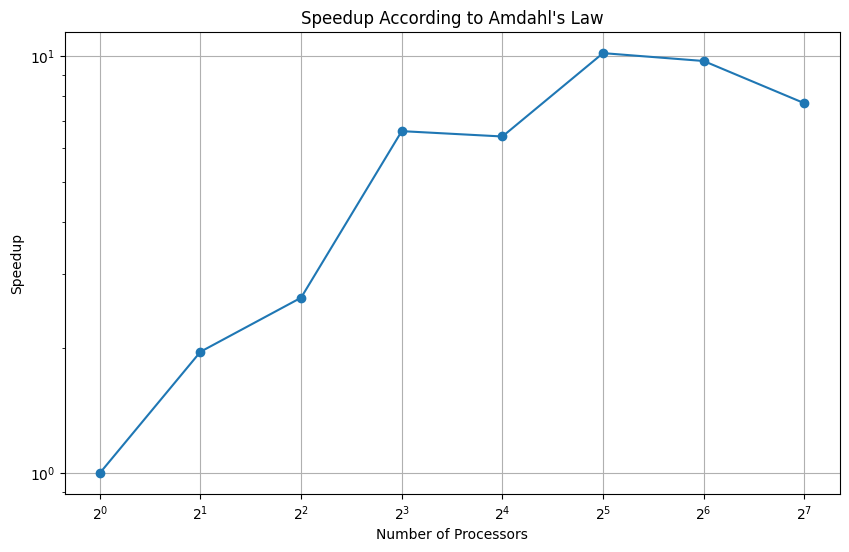

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

def simulate_task(parallel_fraction, total_work_units, num_processors):
    """
    Simulates a computational task based on the parallelizable fraction and number of processors.

    Args:
    - parallel_fraction (float): The fraction of the task that can be parallelized.
    - total_work_units (int): Total amount of work to be done (work units).
    - num_processors (int): Number of processors to simulate.

    Returns:
    - total_time (float): Total time taken to complete the task.
    """
    # Non-parallelizable part of the task
    non_parallel_work_units = int(total_work_units * (1 - parallel_fraction))
    start_time = time.time()
    # Simulate non-parallelizable work (this runs on a single processor)
    for _ in range(non_parallel_work_units):
        np.sqrt(12345.6789)  # Example operation
    non_parallel_time = time.time() - start_time

    # Parallelizable part of the task
    parallel_work_units_per_processor = int((total_work_units * parallel_fraction) / num_processors)
    start_time = time.time()
    # Simulate parallelizable work (divided across processors)
    for _ in range(parallel_work_units_per_processor):
        np.sqrt(12345.6789)  # Example operation
    parallel_time = time.time() - start_time

    # Total time is the non-parallel time plus the parallel time
    total_time = non_parallel_time + parallel_time

    return total_time

# Parameters for the simulation
parallel_fraction = 0.9  # 90% of the task can be parallelized
total_work_units = 100000  # Total work units
num_processors_list = [1, 2, 4, 8, 16, 32, 64,128]  # Different numbers of processors

# Running the simulation for different numbers of processors
times = []
speedups = []
for num_processors in num_processors_list:
    time_taken = simulate_task(parallel_fraction, total_work_units, num_processors)
    times.append(time_taken)
    speedups.append(times[0] / time_taken)  # Speedup is relative to the time with 1 processor
    print(f"Processors: {num_processors}, Time taken: {time_taken:.4f} seconds, Speedup: {speedups[-1]:.2f}x")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_processors_list, speedups, marker='o')
plt.title("Speedup According to Amdahl's Law")
plt.xlabel("Number of Processors")
plt.ylabel("Speedup")
plt.grid(True)
plt.xscale("log", base=2)
plt.yscale("log")
plt.show()


### Explanation of the Code

This Python code simulates the impact of Amdahl's Law on a computational task by varying the number of processors and measuring the time taken for a task with a fixed parallelizable portion.

- **`simulate_task(parallel_fraction, total_work_units, num_processors)` Function**:
  - **`parallel_fraction`**: The fraction of the task that can be parallelized.
  - **`total_work_units`**: The total number of work units (a measure of task size).
  - **`num_processors`**: The number of processors used in the simulation.

- **Non-parallelizable Work**: This portion of the task runs on a single processor, representing the part of the task that cannot benefit from parallelization.

- **Parallelizable Work**: This portion of the task is divided among the available processors, simulating the work that can be done in parallel.

- **Results**:
  - The simulation calculates the total time taken for the task with different numbers of processors.
  - Speedup is calculated relative to the time taken with a single processor.
  - The results are plotted on a log-log scale to visualize how speedup behaves as the number of processors increases.

### Questions to Consider
- How does the speedup change as the number of processors increases?
- What does this tell you about the limitations of parallel computing as described by Amdahl's Law?
- Why does the speedup plateau even as more processors are added?


### Conclusion

Amdahl's Law provides a fundamental insight into the limitations of parallel computing. By simulating a computational task with both parallelizable and non-parallelizable components, this exercise has shown how the speedup is limited by the fraction of the task that cannot be parallelized. This understanding is critical when working with high-performance computing systems, where optimizing both the parallel and sequential portions of tasks can lead to significant performance improvements.

### Additional Resources
- **Books**:
  - "Introduction to Parallel Computing" by Ananth Grama, Anshul Gupta, et al.
  - "Parallel and High Performance Computing" by Robert Robey and Yuliana Zamora.
- **Websites**:
  - [Amdahl's Law on Wikipedia](https://en.wikipedia.org/wiki/Amdahl%27s_law)
  - [Introduction to Parallel Computing](https://computing.llnl.gov/tutorials/parallel_comp/)


## Lesson 1.4: Understanding HPC Benchmarking

HPC Benchmarking is a critical practice in High-Performance Computing (HPC) used to evaluate and compare the performance of different systems. By running standardized benchmarks, administrators and researchers can assess how well a system performs under various workloads, guiding optimization efforts and system selection.

This lesson will cover the basics of HPC benchmarking, key metrics, and how to simulate a simple benchmark using Python.


### Key Concepts

1. **HPC Benchmarking**:
   - **Definition**: HPC Benchmarking involves running specific programs or tests designed to measure the performance of HPC systems. Common benchmarks include HPL (High Performance Linpack), HPCG (High Performance Conjugate Gradients), and STREAM.
   - **Purpose**: The primary goals of benchmarking are to assess system performance, compare different HPC systems, and identify potential bottlenecks.

2. **Key Metrics**:
   - **FLOPS**: Floating-point operations per second, a measure of computational power.
   - **Memory Bandwidth**: The rate at which data can be read from or stored into memory by the processor.
   - **Latency**: The time it takes to complete a single task or operation.
   - **Scalability**: How well a system can maintain performance as more resources (e.g., processors, memory) are added.

3. **Types of Benchmarks**:
   - **HPL (High Performance Linpack)**: Measures the system's ability to solve a dense system of linear equations.
   - **HPCG (High Performance Conjugate Gradients)**: Focuses on real-world computational and data access patterns.
   - **STREAM**: Evaluates sustainable memory bandwidth.


### Practical Exercise: Simulating a Simple HPC Benchmark

In this exercise, you'll write Python code to simulate a simple benchmark that measures the performance of a matrix multiplication task, which is a common operation in scientific computing. This simulation will help you understand how benchmarks can be used to evaluate computational performance.


Matrix size: 100x100, Time taken: 0.0054 seconds
Matrix size: 200x200, Time taken: 0.0011 seconds
Matrix size: 400x400, Time taken: 0.0059 seconds
Matrix size: 800x800, Time taken: 0.0361 seconds
Matrix size: 1600x1600, Time taken: 0.2669 seconds
Matrix size: 3200x3200, Time taken: 2.1512 seconds


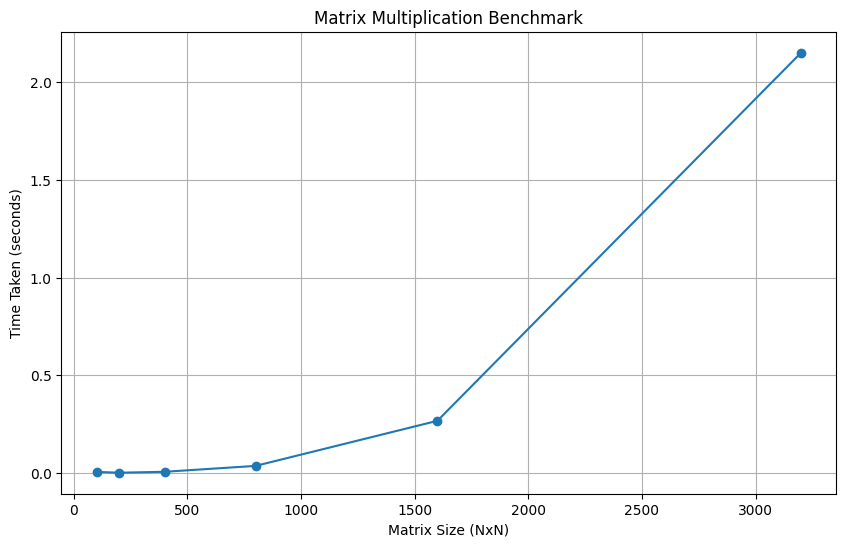

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Function to perform matrix multiplication and measure time taken
def matrix_multiplication_benchmark(size):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    start_time = time.time()
    C = np.dot(A, B)
    end_time = time.time()

    return end_time - start_time

# Sizes of the matrices
sizes = [100, 200, 400, 800, 1600, 3200]

# Running the benchmark
times = []
for size in sizes:
    time_taken = matrix_multiplication_benchmark(size)
    times.append(time_taken)
    print(f"Matrix size: {size}x{size}, Time taken: {time_taken:.4f} seconds")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sizes, times, marker='o')
plt.title("Matrix Multiplication Benchmark")
plt.xlabel("Matrix Size (NxN)")
plt.ylabel("Time Taken (seconds)")
plt.grid(True)
plt.show()


### Explanation of the HPC Benchmark Simulation Code

This Python code simulates a simple HPC benchmark by measuring the time taken to perform matrix multiplication for matrices of different sizes.

- **`matrix_multiplication_benchmark(size)` Function**: This function generates two random matrices of the specified size and multiplies them using NumPy's `dot` function. The time taken to complete the multiplication is measured using Python's `time` module.
- **`sizes`**: A list of matrix sizes (e.g., 100x100, 200x200) to test the benchmark on increasing scales.
- **Benchmark Execution**: The benchmark is run for each matrix size, and the time taken is recorded and printed.
- **Plotting**: The results are plotted using Matplotlib, showing how the time taken for matrix multiplication increases with the size of the matrices.

### Questions to Consider
- How does the time taken for matrix multiplication scale with the size of the matrices?
- What does this tell you about the computational complexity of matrix multiplication?
- How could this benchmark help in evaluating the performance of different HPC systems?


### Analysis and Discussion

From the benchmark results, you can observe how the time taken for matrix multiplication increases as the size of the matrices grows. This is expected, as matrix multiplication is an \(O(N^3)\) operation, meaning the time complexity increases cubically with the size of the matrices.

This simple benchmark provides valuable insights into the computational performance of the system. In a real-world HPC environment, similar benchmarks would be used to evaluate different systems' capabilities and guide decisions on hardware upgrades or system configurations.

### Questions for Further Exploration
- How would the results differ on a multi-core system compared to a single-core system?
- What other operations could you benchmark to evaluate different aspects of system performance, such as memory bandwidth or I/O speed?


# Practical Exercise: Simulating CPU-Bound vs. Memory-Bound Tasks in HPC

In this exercise, we'll write Python code to simulate and compare two types of tasks common in high-performance computing (HPC): a CPU-bound task and a memory-bound task.

### CPU-Bound Task: Matrix Multiplication
Matrix multiplication is a computationally intensive operation often used in scientific computing. The performance of this operation is typically limited by the processing power of the CPU.

### Memory-Bound Task: Memory Bandwidth Test
A memory-bound task, on the other hand, is limited by the speed at which data can be read from or written to memory. This type of task stresses the memory subsystem more than the CPU.

By running these two simulations, we can observe how the nature of a task (whether it is CPU-bound or memory-bound) affects performance and system behavior.

### Exercise Objectives
- Understand the difference between CPU-bound and memory-bound tasks.
- Observe how each type of task scales with increasing workload.
- Analyze the impact of computational complexity and memory access patterns on HPC performance.


Matrix size: 100x100
  CPU-bound (Matrix Multiplication) Time: 0.0007 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0009 seconds
Matrix size: 200x200
  CPU-bound (Matrix Multiplication) Time: 0.0015 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0010 seconds
Matrix size: 400x400
  CPU-bound (Matrix Multiplication) Time: 0.0065 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0021 seconds
Matrix size: 800x800
  CPU-bound (Matrix Multiplication) Time: 0.0362 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0049 seconds
Matrix size: 1600x1600
  CPU-bound (Matrix Multiplication) Time: 0.2673 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0112 seconds
Matrix size: 3200x3200
  CPU-bound (Matrix Multiplication) Time: 3.5241 seconds
  Memory-bound (Memory Bandwidth) Time: 0.0390 seconds


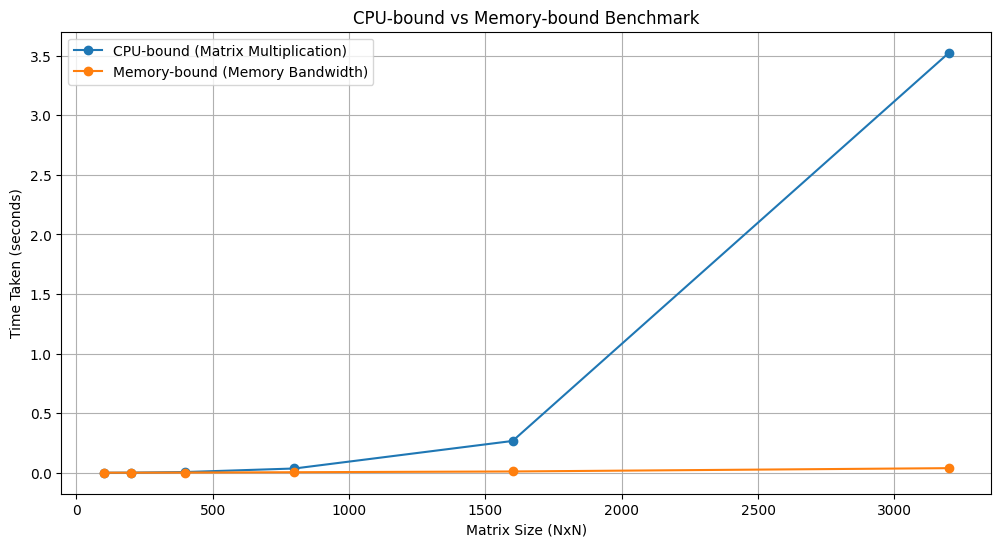

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# CPU-bound task: Matrix multiplication
def matrix_multiplication_benchmark(size):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    start_time = time.time()
    C = np.dot(A, B)
    end_time = time.time()

    return end_time - start_time

# Memory-bound task: Memory bandwidth test
def memory_bandwidth_benchmark(size):
    A = np.random.rand(size, size)

    start_time = time.time()
    for i in range(size):
        A[i, :] = A[i, :] * 2  # Simple operation that stresses memory access
    end_time = time.time()

    return end_time - start_time

# Sizes for the benchmarks
sizes = [100, 200, 400, 800, 1600, 3200]

# Running the benchmarks
cpu_times = []
memory_times = []

for size in sizes:
    cpu_time = matrix_multiplication_benchmark(size)
    memory_time = memory_bandwidth_benchmark(size)

    cpu_times.append(cpu_time)
    memory_times.append(memory_time)

    print(f"Matrix size: {size}x{size}")
    print(f"  CPU-bound (Matrix Multiplication) Time: {cpu_time:.4f} seconds")
    print(f"  Memory-bound (Memory Bandwidth) Time: {memory_time:.4f} seconds")

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(sizes, cpu_times, marker='o', label='CPU-bound (Matrix Multiplication)')
plt.plot(sizes, memory_times, marker='o', label='Memory-bound (Memory Bandwidth)')

plt.title("CPU-bound vs Memory-bound Benchmark")
plt.xlabel("Matrix Size (NxN)")
plt.ylabel("Time Taken (seconds)")
plt.legend()
plt.grid(True)
plt.show()


## Explanation of the Benchmark Simulation Code

### CPU-bound Benchmark: Matrix Multiplication
This benchmark measures the time taken to perform matrix multiplication, a common CPU-bound task. The performance primarily depends on the CPU's ability to perform floating-point operations.

### Memory-bound Benchmark: Memory Bandwidth Test
This benchmark measures the time taken to perform a simple operation that stresses memory access, simulating a memory-bound workload. The performance is limited by the memory bandwidth, i.e., how quickly data can be read from or written to memory.

### Analysis and Discussion
- **CPU-bound Task**: The time taken for matrix multiplication increases significantly with matrix size due to the cubic time complexity (O(N^3)) of the operation.
- **Memory-bound Task**: The time taken for the memory bandwidth test increases more linearly, as the operation is mainly limited by memory access speed rather than computational complexity.

### Questions to Consider
- How do the scaling behaviors of the CPU-bound and memory-bound tasks differ as the matrix size increases?
- What does this tell you about the types of resources (CPU vs. memory) that are critical for different kinds of HPC workloads?
- How could these benchmarks help you understand the performance characteristics of different HPC systems?


# Practical Exercise: Comparing Synthetic Benchmarks and Real Application Benchmarks in HPC

In this exercise, we'll explore the differences between synthetic benchmarks and real application benchmarks in the context of high-performance computing (HPC). We'll write Python code to simulate both types of benchmarks and analyze their respective characteristics and use cases.

### Synthetic Benchmark
A synthetic benchmark is designed to stress specific components of a system, such as the CPU, memory, or storage. It often involves running standardized tests that generate workloads representative of specific performance aspects.

### Real Application Benchmark
A real application benchmark measures the performance of an actual application that would be used in a production environment. This type of benchmark reflects real-world usage scenarios and provides insights into how the system performs under typical operational conditions.

### Exercise Objectives
- Understand the difference between synthetic benchmarks and real application benchmarks.
- Compare how each type of benchmark reflects the performance of HPC systems.
- Analyze the strengths and weaknesses of synthetic and real application benchmarks in evaluating system performance.

### Examples in HPC:
- **Synthetic Benchmark**: HPL (High Performance Linpack) is a widely used synthetic benchmark in HPC that measures the floating-point computation capability of a system by solving a dense system of linear equations.
- **Real Application Benchmark**: HPCG (High Performance Conjugate Gradients) is a real application benchmark that better represents the performance of a system on real-world workloads like those found in scientific computing.


Matrix size: 100x100
  Synthetic Benchmark Time: 0.0064 seconds
  Real Application Benchmark Time: 0.0176 seconds
Matrix size: 200x200
  Synthetic Benchmark Time: 0.0010 seconds
  Real Application Benchmark Time: 0.0758 seconds
Matrix size: 400x400
  Synthetic Benchmark Time: 0.0057 seconds
  Real Application Benchmark Time: 0.1983 seconds
Matrix size: 800x800
  Synthetic Benchmark Time: 0.0483 seconds
  Real Application Benchmark Time: 0.6028 seconds
Matrix size: 1600x1600
  Synthetic Benchmark Time: 0.2960 seconds
  Real Application Benchmark Time: 2.0694 seconds


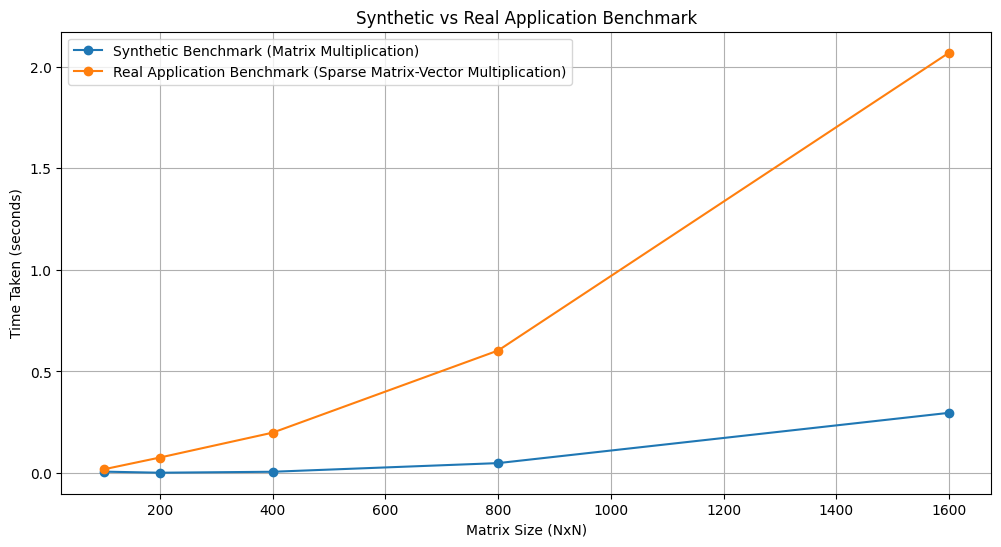

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Synthetic Benchmark: Matrix Multiplication (similar to HPL)
def synthetic_benchmark(size):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    start_time = time.time()
    C = np.dot(A, B)  # Matrix multiplication, stressing CPU and memory
    end_time = time.time()

    return end_time - start_time

# Real Application Benchmark: Sparse Matrix-Vector Multiplication (similar to HPCG)
def real_application_benchmark(size):
    A = np.random.rand(size, size)
    x = np.random.rand(size)

    start_time = time.time()
    y = np.zeros(size)
    for i in range(size):
        for j in range(size):
            if A[i, j] != 0:  # Simulating sparse matrix behavior
                y[i] += A[i, j] * x[j]
    end_time = time.time()

    return end_time - start_time

# Sizes for the benchmarks
sizes = [100, 200, 400, 800, 1600]

# Running the benchmarks
synthetic_times = []
real_app_times = []

for size in sizes:
    synthetic_time = synthetic_benchmark(size)
    real_app_time = real_application_benchmark(size)

    synthetic_times.append(synthetic_time)
    real_app_times.append(real_app_time)

    print(f"Matrix size: {size}x{size}")
    print(f"  Synthetic Benchmark Time: {synthetic_time:.4f} seconds")
    print(f"  Real Application Benchmark Time: {real_app_time:.4f} seconds")

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(sizes, synthetic_times, marker='o', label='Synthetic Benchmark (Matrix Multiplication)')
plt.plot(sizes, real_app_times, marker='o', label='Real Application Benchmark (Sparse Matrix-Vector Multiplication)')

plt.title("Synthetic vs Real Application Benchmark")
plt.xlabel("Matrix Size (NxN)")
plt.ylabel("Time Taken (seconds)")
plt.legend()
plt.grid(True)
plt.show()


## Explanation of the Benchmark Simulation Code

### Synthetic Benchmark: Matrix Multiplication
This synthetic benchmark simulates a scenario where the system's CPU and memory subsystems are stressed by performing a large number of floating-point operations. This is similar to the HPL benchmark used in HPC, which measures a system's peak performance in solving linear equations.

### Real Application Benchmark: Sparse Matrix-Vector Multiplication
This benchmark simulates a more realistic workload, akin to the HPCG benchmark. It involves operations on a sparse matrix, where most of the elements are zero, representing the kind of computational pattern often seen in scientific computing applications. The performance measured here is more indicative of how the system would perform in real-world applications.

### Analysis and Discussion
- **Synthetic Benchmark**: Tends to show how well a system can handle idealized, computationally intensive tasks, providing a measure of peak performance.
- **Real Application Benchmark**: Reflects the system's performance on more complex, realistic tasks with memory access patterns, such as sparse matrix operations, which are common in scientific and engineering applications.

### Questions to Consider
- How do the performance characteristics differ between the synthetic and real application benchmarks as matrix size increases?
- Why might a synthetic benchmark like HPL not fully represent the real-world performance of an HPC system?
- In what scenarios might it be more valuable to rely on a real application benchmark rather than a synthetic one?

### Further Exploration
- How would the results differ on different hardware architectures, such as a CPU-only system versus a GPU-accelerated system?
- What other real application benchmarks could be used to evaluate specific types of HPC workloads, such as data-intensive tasks or I/O performance?
